# Multiple Hypothesis Testing Corrections

When conducting online A/B tests or large-scale experiments, we often analyze multiple dependent variables simultaneously. Analyzing multiple KPIs introduces a significant statistical challenge: the multiple testing problem.

In classical hypothesis testing, the significance level $\alpha$ controls the probability of a false positive (Type I error), typically $\alpha=0.05$. While this ensures a 5% chance of a false positive for a single test, the likelihood of detecting at least one false positive grows rapidly when conducting multiple tests. For example, testing 20 KPIs independently at $\alpha = 0.05$ results in a 64% chance of at least one false positive—calculated as $1 - (1 - 0.05)^{20} \approx 0.64$. This issue, known as the multiple testing problem, can lead to false claims of significant effects when none exist.

To address this, the concept of controlling the **Familywise Error Rate (FWER)** has been widely adopted. FWER controls the probability of at least one Type I error across a family of hypotheses. Several correction methods exist to mitigate the multiple testing problem, including:

- **Bonferroni Correction**: A simple and conservative method that adjusts the significance level for each test by dividing $\alpha$ by the number of tests.
- **Romano-Wolf & Westfall-Young Stepwise Procedures**: Two more powerful methods that use resampling techniques to control the FWER.

This vignette demonstrates how these methods effectively control the FWER in a variety of scenarios. We will compare their performance and highlight the trade-offs between simplicity and statistical power. Specifically, we show that while Bonferroni provides strong error control, it is conservative in many practical applications. In contrast, Romano-Wolf and Westfall-Young methods are more powerful, offering greater sensitivity to detect true effects while maintaining robust control of the FWER.

## What is a Family-Wise Error Rate (FWER)? 

Suppose that we are running an experiment and want to test if our treatment impacts 20 different dependent variables (KPIs). For any given independent test, the chance of a false positive is given by the (significance) **level** of the individual test, which is most commonly set to $\alpha = 0.05$. Formally, we can define the false positive rate for a single hypothesis $H$ as:

$$
P(\text{reject } H \mid H \text{ is true}) = \alpha
$$

For a **family of tests** $S = {s \in \{1, \dots, P\} }$ hypotheses $\{H_{s}\}_{s \in S}$, we can analogously define the **family-wise error rate (FWER)** as:

$$
P(\text{reject at least one } H_{s} \text{ with } s \in I) = \alpha
$$

where $I$ is the set of **true hypotheses**. In other words, the FWER is the probability of making at least one false positive across all tests in the family.


## Setup

In a first step, we create a data set with multiple (potentially correlated) dependent variables that share a common set of covariates. 
All simulations in this notebook are greatly inspired by Clarke, Romano & Wolf (Stata Journal, 2020).

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from great_tables import loc, style
from joblib import Parallel, delayed
from tqdm import tqdm

import pyfixest as pf

ImportError: cannot import name '_c_internal_utils' from partially initialized module 'matplotlib' (most likely due to a circular import) (c:\Users\alexa\Documents\pyfixest\.pixi\envs\dev\Lib\site-packages\matplotlib\__init__.py)

In [ ]:
N = 100
n_covariates = 5
n_depvars = 20

In [ ]:
def get_data(N, n_covariates, n_depvars, rho, seed):
    "Simulate data with true nulls."
    rng = np.random.default_rng(seed)
    Omega = np.eye(n_depvars)
    X = rng.standard_normal((N, n_covariates))
    u_joint = np.random.multivariate_normal(np.zeros(n_depvars), Omega, N)
    beta = np.zeros((n_covariates, n_depvars))
    y = X @ beta + u_joint

    data = pd.DataFrame(X, columns=[f"X{i}" for i in range(n_covariates)])
    data = data.assign(**{f"y{i}": y[:, i] for i in range(n_depvars)})

    return data

In [ ]:
data = get_data(
    N=N, n_covariates=n_covariates, n_depvars=n_depvars, rho=0.5, seed=12345
)
data.head()

,X0,X1,X2,X3,X4,y0,y1,y2,y3,y4,...,y10,y11,y12,y13,y14,y15,y16,y17,y18,y19
0,-1.423825,1.263728,-0.870662,-0.259173,-0.075343,0.285444,-0.613527,1.064762,0.941035,-0.188382,...,0.947734,0.505579,-2.838629,-0.563997,1.757725,-0.187876,2.554182,-2.486495,0.216818,0.298878
1,-0.740885,-1.367793,0.648893,0.361058,-1.952863,1.365574,0.404626,-1.869440,-0.008121,2.129185,...,0.439416,-1.992477,-0.002794,1.603059,-0.244048,0.880147,0.700935,-0.375832,1.113939,0.279370
2,2.347410,0.968497,-0.759387,0.902198,-0.466953,0.215444,-0.282206,0.720051,0.366021,1.051319,...,0.272646,-0.507247,-0.784782,-1.007066,0.840372,-1.150062,2.082881,0.583346,1.077486,0.027789
3,-0.060690,0.788844,-1.256668,0.575858,1.398979,-1.065016,1.185823,0.970361,-0.765870,0.479013,...,-1.007019,0.924188,1.949084,-1.560250,1.167244,-0.837087,0.360323,0.640585,0.527408,-0.033194
4,1.322298,-0.299699,0.902919,-1.621583,-0.158189,0.664518,1.456532,1.858938,-0.285083,-0.379121,...,-0.960765,-0.238118,-1.055520,-0.486306,0.583903,0.718977,-0.122756,0.545447,0.174667,0.926524


Now that we have our data set at hand, we can fit 20 regression models - one for each dependent variable. To do so, we will use 
pyfixest's multiple estimation syntax.

In [ ]:
dependent_vars = " + ".join([f"y{i}" for i in range(20)])
independent_vars = " + ".join([f"X{i}" for i in range(5)])
fml = f"{dependent_vars} ~ {independent_vars}"

In [ ]:
fit = pf.feols(fml, data=data, vcov="hetero")

In [ ]:
(pf.etable(fit).tab_style(style=style.fill(color="yellow"), locations=loc.body(rows=1)))

GT(_tbl_data=  level_0        level_1                    0                    1  \
0    coef             X0   0.079 <br> (0.119)   0.111 <br> (0.108)   
1    coef             X1  -0.064 <br> (0.093)  -0.065 <br> (0.108)   
2    coef             X2  -0.165 <br> (0.116)  -0.181 <br> (0.125)   
3    coef             X3  -0.110 <br> (0.089)   0.133 <br> (0.108)   
4    coef             X4   0.017 <br> (0.114)   0.124 <br> (0.128)   
5    coef      Intercept   0.121 <br> (0.101)   0.020 <br> (0.115)   
6   stats   Observations                  100                  100   
7   stats      S.E. type               hetero               hetero   
8   stats  R<sup>2</sup>                0.039                0.068   

                     2                    3                    4  \
0   0.088 <br> (0.105)   0.158 <br> (0.094)   0.033 <br> (0.112)   
1  -0.055 <br> (0.107)  -0.055 <br> (0.097)  -0.013 <br> (0.101)   
2   0.107 <br> (0.090)  -0.027 <br> (0.094)  -0.080 <br> (0.111)   
3   0.018 <br> (0.110)   0.006 <br> (0.090)   0.036 <br> (0.100)   
4   0.126 <br> (0.107)  -0.014 <br> (0.085)  -0.120 <br> (0.100)   
5   0.191 <br> (0.108)   0.103 <br> (0.086)  -0.069 <br> (0.103)   
6                  100                  100                  100   
7               hetero               hetero               hetero   
8                0.037                0.033                0.022   

                     5                     6                    7  ...  \
0  -0.011 <br> (0.100)  -0.223* <br> (0.100)   0.020 <br> (0.117)  ...   
1   0.036 <br> (0.092)   -0.038 <br> (0.100)  -0.052 <br> (0.112)  ...   
2   0.009 <br> (0.079)    0.185 <br> (0.098)  -0.023 <br> (0.108)  ...   
3  -0.083 <br> (0.105)   0.202* <br> (0.094)   0.105 <br> (0.118)  ...   
4   0.067 <br> (0.094)    0.118 <br> (0.105)  -0.035 <br> (0.107)  ...   
5  -0.090 <br> (0.096)   -0.010 <br> (0.099)   0.021 <br> (0.103)  ...   
6                  100                   100                  100  ...   
7               hetero                hetero               hetero  ...   
8                0.015                 0.144                0.015  ...   

                    10                   11                   12  \
0   0.009 <br> (0.114)   0.023 <br> (0.106)   0.002 <br> (0.099)   
1   0.002 <br> (0.092)   0.049 <br> (0.124)  -0.017 <br> (0.102)   
2  -0.008 <br> (0.095)   0.175 <br> (0.116)   0.153 <br> (0.091)   
3   0.015 <br> (0.115)   0.095 <br> (0.093)   0.030 <br> (0.103)   
4   0.004 <br> (0.101)   0.035 <br> (0.120)  0.200* <br> (0.098)   
5   0.103 <br> (0.111)  -0.130 <br> (0.112)   0.132 <br> (0.098)   
6                  100                  100                  100   
7               hetero               hetero               hetero   
8                0.000                0.035                0.068   

                   13                     14                   15  \
0  0.100 <br> (0.092)    -0.068 <br> (0.098)  -0.022 <br> (0.100)   
1  0.061 <br> (0.099)    -0.023 <br> (0.086)  -0.017 <br> (0.090)   
2  0.127 <br> (0.090)     0.042 <br> (0.105)   0.142 <br> (0.094)   
3  0.076 <br> (0.112)    -0.080 <br> (0.085)   0.067 <br> (0.106)   
4  0.011 <br> (0.119)  -0.222** <br> (0.083)  -0.131 <br> (0.095)   
5  0.004 <br> (0.104)    -0.043 <br> (0.088)  -0.046 <br> (0.100)   
6                 100                    100                  100   
7              hetero                 hetero               hetero   
8               0.037                  0.079                0.040   

                    16                   17                   18  \
0   0.153 <br> (0.123)  0.231* <br> (0.095)   0.113 <br> (0.120)   
1   0.159 <br> (0.113)   0.032 <br> (0.122)  -0.144 <br> (0.100)   
2  -0.081 <br> (0.116)  -0.195 <br> (0.105)  -0.200 <br> (0.107)   
3  -0.057 <br> (0.127)  -0.016 <br> (0.106)   0.051 <br> (0.102)   
4  -0.029 <br> (0.113)   0.146 <br> (0.106)  -0.104 <br> (0.109)   
5   0.115 <br> (0.111)  -0.084 <br> (0.114)   0.066 <br> (0.109)   
6               

We see that our estimation produces multiple false positives for the effect of X1 on multiple dependent variables. Recall that 
we had simulated X1 to have **no effect** on any of the dependent variables. Still, the estimation procedure produces a significant
effect for X1 on multiple dependent variables. 

`PyFixest` provides three functions to adjust inference for multiple testing: `pf.bonferroni()`, `pf.rwolf()`, and `pf.wyoung()`.
All three share a common API.

In [ ]:
pval_bonferroni = (
    pf.bonferroni(fit.to_list(), param="X1").xs("Bonferroni Pr(>|t|)").values
)

pval_rwolf = (
    pf.rwolf(fit.to_list(), param="X1", reps=1000, seed=22).xs("RW Pr(>|t|)").values
)

pval_wyoung = (
    pf.wyoung(fit.to_list(), param="X1", reps=1000, seed=22).xs("WY Pr(>|t|)").values
)

In [ ]:
(
    pf.etable(
        fit,
        custom_model_stats={
            "Bonferroni: pval(X1)": pval_bonferroni.round(4).tolist(),
            "RW: pval(X1)": pval_rwolf.round(4).tolist(),
            "WY: pval(X1)": pval_wyoung.round(4).tolist(),
        },
    ).tab_style(style=style.fill(color="yellow"), locations=loc.body(rows=[6, 7, 8]))
)

GT(_tbl_data=   level_0               level_1                    0                    1  \
0     coef                    X0   0.192 <br> (0.105)  -0.125 <br> (0.122)   
1     coef                    X1   0.053 <br> (0.104)   0.030 <br> (0.124)   
2     coef                    X2  -0.164 <br> (0.095)   0.140 <br> (0.112)   
3     coef                    X3   0.022 <br> (0.108)  -0.041 <br> (0.117)   
4     coef                    X4  -0.109 <br> (0.099)  -0.071 <br> (0.120)   
5     coef             Intercept   0.169 <br> (0.105)   0.094 <br> (0.117)   
6    stats  Bonferroni: pval(X1)                  1.0                  1.0   
7    stats          RW: pval(X1)                  1.0                  1.0   
8    stats          WY: pval(X1)                  1.0                  1.0   
9    stats          Observations                  100                  100   
10   stats             S.E. type               hetero               hetero   
11   stats         R<sup>2</sup>                0.078                0.030   

                      2                    3                     4  \
0   -0.184 <br> (0.095)   0.067 <br> (0.110)  -0.279* <br> (0.118)   
1    0.162 <br> (0.084)   0.024 <br> (0.111)   -0.037 <br> (0.104)   
2    0.058 <br> (0.103)  -0.065 <br> (0.095)    0.003 <br> (0.113)   
3   -0.015 <br> (0.098)   0.042 <br> (0.088)   -0.121 <br> (0.096)   
4    0.026 <br> (0.093)   0.064 <br> (0.074)    0.062 <br> (0.127)   
5   -0.021 <br> (0.097)  0.188* <br> (0.090)   -0.034 <br> (0.112)   
6                   1.0                  1.0                   1.0   
7                0.7273                  1.0                   1.0   
8                 0.727                  1.0                   1.0   
9                   100                  100                   100   
10               hetero               hetero                hetero   
11                0.063                0.017                 0.079   

                       5                    6                    7  ...  \
0    -0.064 <br> (0.123)  -0.041 <br> (0.093)   0.079 <br> (0.089)  ...   
1     0.087 <br> (0.088)  -0.011 <br> (0.089)  -0.075 <br> (0.091)  ...   
2   0.282** <br> (0.098)   0.077 <br> (0.110)   0.081 <br> (0.110)  ...   
3    -0.037 <br> (0.101)   0.008 <br> (0.090)  -0.108 <br> (0.090)  ...   
4     0.021 <br> (0.088)  -0.035 <br> (0.104)  -0.082 <br> (0.085)  ...   
5    -0.047 <br> (0.101)   0.048 <br> (0.098)  -0.161 <br> (0.092)  ...   
6                    1.0                  1.0                  1.0  ...   
7                  0.996                  1.0                0.998  ...   
8                  0.996                  1.0                0.998  ...   
9                    100                  100                  100  ...   
10                hetero               hetero               hetero  ...   
11                 0.085                0.009                0.048  ...   

                      10                   11                   12  \
0     0.059 <br> (0.096)  -0.163 <br> (0.094)   0.172 <br> (0.110)   
1    -0.060 <br> (0.101)   0.139 <br> (0.089)  -0.183 <br> (0.109)   
2     0.116 <br> (0.109)   0.003 <br> (0.107)  -0.138 <br> (0.109)   
3    -0.064 <br> (0.109)  -0.065 <br> (0.098)   0.053 <br> (0.100)   
4     0.084 <br> (0.105)  -0.123 <br> (0.114)  -0.142 <br> (0.107)   
5   -0.227* <br> (0.095)   0.006 <br> (0.101)   0.136 <br> (0.102)   
6                    1.0                  1.0                  1.0   
7                    1.0               0.8921               0.8521   
8                    1.0                0.892                0.852   
9                    100                  100                  100   
10                hetero               hetero               hetero   
11                 0.033                0.061                0.097   

                     13                   14                   15  \
0    0.090 <br> (0.122)   0.032 <br> (0.104)   0.025 <br> (0.106)   
1   -0.038 <br> (0.117)  -0.038 <br>

We quickly see that the corrected p-values do not flag any false positives. 

## Controlling for the Familiy-Wise Error Rate (FWER)

We now show by means of simulation that the three methods control the family-wise error rate (FWER). To do so, we simulate 1000 
data sets imposing true nulls for the effect of X1 on all of 20 created dependent variables. 
For each simulation, we then count if the methods flag more than one false positive and report our results. 

In [ ]:
def compute_family_rejection(seed, rho):
    "Simulate data, estimate models, and compute family rejection rates."
    data = get_data(N, n_covariates, n_depvars, rho, seed=seed)
    fit = pf.feols(fml=fml, data=data, vcov="hetero")
    df = fit.tidy().reset_index().set_index("Coefficient").xs("X1")

    df["Pr(>|t|) reject"] = df["Pr(>|t|)"] < 0.05
    df["Bonferroni reject"] = (
        pf.bonferroni(fit, param="X1").xs("Bonferroni Pr(>|t|)").values < 0.05
    )
    df["rwolf reject"] = (
        pf.rwolf(fit, param="X1", reps=1000, seed=seed * 11).xs("RW Pr(>|t|)").values
        < 0.05
    )
    df["wyoung reject"] = (
        pf.wyoung(fit, param="X1", reps=1000, seed=seed * 11).xs("WY Pr(>|t|)").values
        < 0.05
    )

    # Compute family rejection means
    family_rejection = {
        "Pr(>|t|) reject family": df["Pr(>|t|) reject"].sum() > 0,
        "Bonferroni reject family": df["Bonferroni reject"].sum() > 0,
        "rwolf reject family": df["rwolf reject"].sum() > 0,
        "wyoung reject family": df["wyoung reject"].sum() > 0,
    }

    return pd.Series(family_rejection)

In [ ]:
def run_fwer_simulation(n_iter, rho):
    "Run simulation for family-wise error rate."
    results = Parallel(n_jobs=-1)(
        delayed(compute_family_rejection)(seed, rho=rho) for seed in tqdm(range(n_iter))
    )
    return pd.concat(results).reset_index().groupby("index").mean()

In [ ]:
run_fwer_simulation(n_iter=1000, rho=0.5)

100%|██████████| 1000/1000 [19:03<00:00,  1.14s/it]


,0
index,
Bonferroni reject family,0.069
Pr(>|t|) reject family,0.694
rwolf reject family,0.043
wyoung reject family,0.043


We see that all three correction methods get close to the desired 5% level. In contrast, the uncorrected method produces the expected much higher family-wise error rate. 

## Power 

Now that we've seen that all three methods effectively handle false positives, let's see how well they avoid **false negatives**. 
In other words, we will study how powerful all three methods are in detecting true effects. 

To do so, we slightly have to adjust the data generating process. Instead of simulating the impact of X1 on all dependent variables 
to be zero (a true null effect), we will now simulate the impact of X1 to be $0.5$ for all dependent variables. Hence 
we simulate **true positives** and count how often we correctly detect the true effect, or, equivalently stated, how often we correctly reject 
the null of no treatment effect. 

In [ ]:
def get_data_true_effect(N, n_covariates, n_depvars, rho=0.5, seed=12345, effect=0.1):
    "Generate data with true positives."
    rng = np.random.default_rng(seed)
    Omega = np.eye(n_depvars)
    Omega[Omega != 1] = rho
    X = rng.standard_normal((N, n_covariates))
    u_joint = np.random.multivariate_normal(np.zeros(n_depvars), Omega, N)
    beta = np.zeros((n_covariates, n_depvars))
    beta[1, :] = effect
    y = X @ beta + u_joint

    data = pd.DataFrame(X, columns=[f"X{i}" for i in range(n_covariates)])
    data = data.assign(**{f"y{i}": y[:, i] for i in range(n_depvars)})

    return data

In [ ]:
data_true = get_data_true_effect(
    N=N, n_covariates=n_covariates, n_depvars=n_depvars, rho=0.5, seed=12345, effect=0.5
)
fit = pf.feols(fml, data=data_true)

In [ ]:
(
    pf.etable(fit).tab_style(
        style=style.fill(color="yellow"), locations=loc.body(rows=[1])
    )
)

GT(_tbl_data=  level_0        level_1                      0                      1  \
0    coef             X0    -0.108 <br> (0.103)    -0.152 <br> (0.116)   
1    coef             X1  0.538*** <br> (0.099)  0.493*** <br> (0.112)   
2    coef             X2     0.081 <br> (0.101)     0.026 <br> (0.114)   
3    coef             X3    -0.068 <br> (0.104)    -0.110 <br> (0.117)   
4    coef             X4    -0.063 <br> (0.101)     0.013 <br> (0.114)   
5    coef      Intercept    -0.007 <br> (0.100)    -0.061 <br> (0.113)   
6   stats   Observations                    100                    100   
7   stats      S.E. type                    iid                    iid   
8   stats  R<sup>2</sup>                  0.259                  0.202   

                       2                      3                     4  \
0   -0.243* <br> (0.113)    -0.026 <br> (0.112)   -0.158 <br> (0.109)   
1  0.589*** <br> (0.109)  0.503*** <br> (0.108)  0.340** <br> (0.106)   
2     0.094 <br> (0.111)     0.094 <br> (0.110)    0.008 <br> (0.108)   
3    -0.033 <br> (0.114)    -0.098 <br> (0.113)   -0.127 <br> (0.110)   
4    -0.142 <br> (0.111)     0.002 <br> (0.110)    0.086 <br> (0.107)   
5    -0.010 <br> (0.110)     0.060 <br> (0.109)   -0.035 <br> (0.107)   
6                    100                    100                   100   
7                    iid                    iid                   iid   
8                  0.264                  0.214                 0.146   

                       5                      6                      7  ...  \
0    -0.132 <br> (0.108)    -0.155 <br> (0.104)    -0.180 <br> (0.114)  ...   
1  0.493*** <br> (0.104)  0.568*** <br> (0.100)  0.590*** <br> (0.110)  ...   
2    -0.036 <br> (0.106)    -0.054 <br> (0.102)    -0.014 <br> (0.112)  ...   
3    -0.086 <br> (0.109)    -0.056 <br> (0.104)    -0.094 <br> (0.115)  ...   
4    -0.092 <br> (0.106)    -0.059 <br> (0.102)     0.030 <br> (0.112)  ...   
5     0.003 <br> (0.105)    -0.013 <br> (0.101)    -0.014 <br> (0.111)  ...   
6                    100                    100                    100  ...   
7                    iid                    iid                    iid  ...   
8                  0.226                  0.288                  0.269  ...   

                      10                     11                     12  \
0    -0.066 <br> (0.109)    -0.005 <br> (0.115)   -0.214* <br> (0.101)   
1  0.375*** <br> (0.105)  0.411*** <br> (0.111)  0.452*** <br> (0.098)   
2     0.128 <br> (0.107)    -0.043 <br> (0.113)     0.039 <br> (0.099)   
3    -0.099 <br> (0.110)    -0.003 <br> (0.116)     0.032 <br> (0.102)   
4     0.068 <br> (0.107)    -0.134 <br> (0.113)    -0.012 <br> (0.099)   
5    -0.003 <br> (0.106)     0.071 <br> (0.112)     0.117 <br> (0.098)   
6                    100                    100                    100   
7                    iid                    iid                    iid   
8                  0.151                  0.149                  0.207   

                      13                     14                     15  \
0    -0.183 <br> (0.115)    -0.007 <br> (0.099)    -0.138 <br> (0.105)   
1  0.586*** <br> (0.111)  0.438*** <br> (0.096)  0.558*** <br> (0.101)   
2     0.053 <br> (0.113)    -0.048 <br> (0.097)     0.027 <br> (0.103)   
3    -0.157 <br> (0.116)    -0.085 <br> (0.100)    -0.017 <br> (0.106)   
4    -0.021 <br> (0.112)     0.046 <br> (0.097)     0.076 <br> (0.103)   
5     0.022 <br> (0.112)    -0.013 <br> (0.097)    -0.034 <br> (0.102)   
6                    100                    100                    100   
7                    iid                    iid                    iid   
8                  0.273                  0.218                  0.267   

                      16                     17                     18  \
0    -0.104 <br> (0.107)    -0.138 <br> (0.111)    -0.102 <br> (0.110)   
1  0.408*** <br> (0.103)  0.442*** <br> (0.107)  0.498*** <br> (0.106)   
2    -0.021 <br> (0.

We will now study power more systematically via a simulation. More concretely, we will compute how often 
we detect the **true effect** of **X1 on Y1, Y2, ..., etc** given a fixed sample size $N$ using "uncorrected" p-values, 
the Bonferroni, Romano-Wolf and Westfall-Young methods. 

In [ ]:
def compute_power(seed, rho, effect):
    "Simulate data, estimate models, and compute power."
    data = get_data_true_effect(
        N, n_covariates, n_depvars, rho, seed=seed, effect=effect
    )
    fit = pf.feols(
        fml=fml, data=data, vcov="hetero"
    )  # model '1' regresses on Y1 - we're only interested in the power of this specific test
    df = fit.tidy().reset_index().set_index("Coefficient").xs("X1")

    df["Pr(>|t|) detect"] = df["Pr(>|t|)"] < 0.05
    df["Bonferroni detect"] = (
        pf.bonferroni(fit, param="X1").xs("Bonferroni Pr(>|t|)").values < 0.05
    )
    df["rwolf detect"] = (
        pf.rwolf(fit, param="X1", reps=200, seed=seed * 11).xs("RW Pr(>|t|)").values
        < 0.05
    )
    df["wyoung detect"] = (
        pf.wyoung(fit, param="X1", reps=200, seed=seed * 11).xs("WY Pr(>|t|)").values
        < 0.05
    )

    # Compute family rejection means
    detect_effect = {
        "Pr(>|t|) detect effect": df["Pr(>|t|) detect"].mean(),
        "Bonferroni detect effect": df["Bonferroni detect"].mean(),
        "rwolf detect effect": df["rwolf detect"].mean(),
        "wyoung detect effect": df["wyoung detect"].mean(),
    }

    detect_effect_df = pd.DataFrame(detect_effect, index=[effect])
    return detect_effect_df

In [ ]:
def run_power_simulation(n_iter, rho, effect, nthreads=-1):
    "Run simulation for power."
    seeds = list(range(n_iter))
    results = Parallel(n_jobs=nthreads)(
        delayed(compute_power)(seed, rho=rho, effect=effect) for seed in tqdm(seeds)
    )

    return pd.concat(results).mean()

In [ ]:
run_power_simulation(n_iter=1000, rho=0.5, effect=0.4)

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\alexa\Documents\pyfixest\.pixi\envs\dev\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 1000/1000 [12:00<00:00,  1.39it/s]


Pr(>|t|) detect effect      0.97045
Bonferroni detect effect    0.78485
rwolf detect effect         0.86985
wyoung detect effect        0.86985
dtype: float64

We see that the "unadjusted" method detects the "true effects" at the highest frequency with on average 97% correctly detected effects. Does this mean that we should use uncorrected tests then? Well, maybe, but these do not control the family-wise error rate. While we have a better chance to detect a true effect, we also have a higher risk of flagging false positives. 

Additionally, it looks as if the rwolf and wyoung methods detect the true positives at a slightly higher rate than the Bonferroni method. 

Do these findings generalize to other effect sizes? We can check this by simply imposing 
different effects on the data generating process and repeating the previous exercise 
multiple times. 

In [ ]:
def run_power_simulation_vary_effect():
    "Run power simulations with varying effect sizes."
    n_points = 10
    max_val = 0.7

    effects = (
        np.sign(np.linspace(-1, 1, n_points))
        * max_val
        * (np.linspace(-1, 1, n_points) ** 2)
    )

    res_list = []
    for effect_size in tqdm(effects):
        res = run_power_simulation(n_iter=1000, rho=0.5, effect=effect_size)
        res["effect"] = effect_size
        res_list.append(res)
    return pd.concat(res_list, axis=1).T.set_index("effect")


res = run_power_simulation_vary_effect()

100%|██████████| 10/10 [1:53:04<00:00, 678.48s/it]


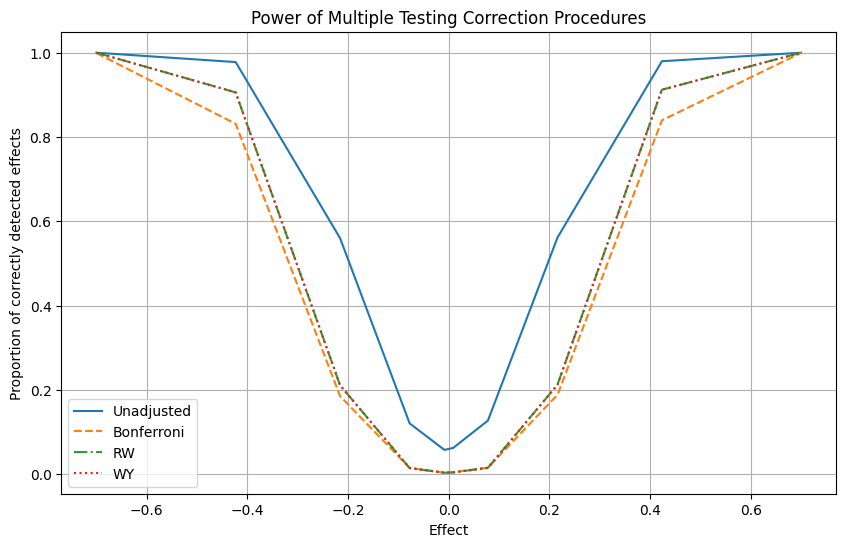

In [ ]:
column_to_label_dict = {
    "Pr(>|t|) detect effect": "Unadjusted",
    "Bonferroni detect effect": "Bonferroni",
    "rwolf detect effect": "RW",
    "wyoung detect effect": "WY",
}

plt.figure(figsize=(10, 6))
line_styles = ["-", "--", "-.", ":"]
for column, line_style in zip(res.columns, line_styles):
    plt.plot(
        res.index, res[column], linestyle=line_style, label=column_to_label_dict[column]
    )

plt.title("Power of Multiple Testing Correction Procedures")
plt.xlabel("Effect")
plt.ylabel("Proportion of correctly detected effects")
plt.legend()
plt.grid()
plt.show()

We see that for any simulated effect size, the Romano-Wolf and Westfall-Young methods detect a higher share of true positives than the Bonferroni method: they have **higher power**.

## Literature 

- Clarke, Damian, Joseph P. Romano, and Michael Wolf. "The Romano–Wolf multiple-hypothesis correction in Stata." The Stata Journal 20.4 (2020): 812-843.
- Romano, Joseph P., and Michael Wolf. "Stepwise multiple testing as formalized data snooping." Econometrica 73.4 (2005): 1237-1282.
- Westfall, Peter H., and S. Stanley Young. Resampling-based multiple testing: Examples and methods for p-value adjustment. Vol. 279. John Wiley & Sons, 1993.